# YOLOv9 Skin Cancer Object Detection
---

The dataset utilized in this notebook is the Skin cancer: HAM10000 dataset available on kaggle ([link](https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification)). The dataset comes with 10,000 images of various types of skin cancer photos. Specifically, there are 7 different types of skin cancers in the dataset. Each photo is of 1 type of cancer and comes with a segmentation mask. 

The goal for this notebook is to practice object detection using the YOLOv9 model made available by [ultralytics](https://www.ultralytics.com/). As such, the segmentation mask is used to derive the bounding box information to train the model. The goal is not to train the best object detection model, but to develop a program to finetune the YOLOv9 model on the dataset. This is because of the limit computing resources available on Kaggle.

In [1]:
# install yolo library
!pip install ultralytics --quiet

In [2]:
# import standard python libraries
from pathlib import Path
from functools import partial
from glob import glob
import os

# import external python libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import skimage
import matplotlib.pyplot as plt
import torch
import ultralytics
import wandb
wandb.init(mode="disabled")

# define directories
input_directory = Path('/kaggle/input/ham1000-segmentation-and-classification')
output_directory = Path('/kaggle/working/dataset')
if not output_directory.is_dir():
    output_directory.mkdir()
    
# define seed for reproducibility 
seed = 1234

# Create Dataset Split And YAML File
---

The YOLOv9 model is trained by providing it with a YAML file. The contents of the YAML file are as follows:

```text
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco8  # dataset root dir
train: images/train  # train images (relative to 'path') 4 images
val: images/val  # val images (relative to 'path') 4 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: person
  1: bicycle
  2: car
  # ...
  77: teddy bear
  78: hair drier
  79: toothbrush
```

To generate the YAML file, the dataset is split using a `60-20-20` split for train, validation, and testing. The split is stratified on the classes label to ensure the distribution across the 3 splits are similar.

By default, the YOLOv9 model takes in a square image of size `640 x 640`. The algorithm can be modified to take in other sized images, however, I choose to resize the images from `450 x 600` to `640 x 640`. 

The bounding box was obtained using detecting blobs within the segmentation mask and extracting the center coordinates and size. The measurements were scaled to `[0, 1]` using the width and height of the original image.

In [3]:
# load ground truth
ground_truth = pd.read_csv(input_directory / 'GroundTruth.csv')
ground_truth.head(5)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# create train, validation, test split
# 60-20-20 split
ground_truth['class'] = np.argmax(ground_truth.iloc[:, 1:])
remaining, test = train_test_split(ground_truth, test_size=0.2, random_state=seed, stratify=ground_truth['class'])
train, valid = train_test_split(remaining, test_size=0.25, random_state=seed, stratify=remaining['class'])

print(f"Train size: {len(train)}")
print(f"Valid size: {len(valid)}")
print(f"Test size : {len(test)}")

Train size: 6009
Valid size: 2003
Test size : 2003


In [5]:
imgsz = 640

def compute_class(x: pd.Series) -> int:
    """Extract the class id for the record"""
    classes = x.iloc[1:]
    class_id = np.argmax(classes)
    return class_id

def compute_object_positions(x: pd.Series) -> list[tuple[float, float, float, float]]:
    """Compute the positions of various objects within the image"""
    # get file path
    filename = x['image'] + '_segmentation.png'
    filepath = input_directory / 'masks' / filename
    
    # load mask
    # mask is black and white png file
    # when converted to gray scale, black maps to 0 and white maps to 255
    # divide by 255 to convert to 0,1 binary mask
    # yolo requires image sizes to be multiple of 32
    mask = skimage.io.imread(filepath, as_gray=True)
    mask = skimage.transform.resize(mask, (imgsz, imgsz)).astype(np.uint8)
    h, w = mask.shape
    
    # get object position
    # in case there are multiple white blobs within each mask
    # get each white region separately 
    output = []
    regions = skimage.measure.label(mask)
    for region in skimage.measure.regionprops(regions):
        # calculate center
        min_row, min_col, max_row, max_col = region.bbox
        center_x = (min_col + max_col) // 2
        center_y = (min_row + max_row) // 2
        
        # calculate width and height
        width = max_col - min_col
        height = max_row - min_row

        # normalize
        center_x, width = center_x / w, width / w
        center_y, height = center_y / h, height / h
        output.append((center_x, center_y, width, height))
    
    return output

def create_output_file(x: pd.Series, segment: str) -> None:
    """Create target file for record"""
    # compute outputs
    class_id = compute_class(x)
    object_positions = compute_object_positions(x)
    
    # get filepath
    filename = x['image'] + '.txt'
    filepath = output_directory / segment / filename
    if not (output_directory / segment).is_dir():
        (output_directory / segment).mkdir()
    
    # construct content of output file
    content = "\n".join([str(class_id) + ' ' + ' '.join([f"{a} {b} {c} {d}" for a, b, c, d in object_positions])])
    # yolo does not need a output file if there are no objects
    if len(object_positions) != 0:
        with open(filepath, 'w') as file:
            file.write(content)
            
def move_image(x: pd.Series, segment: str) -> None:
    """Move the image into the dataset directory"""
    # get filepath
    filename = x['image'] + '.jpg'
    filepath = input_directory / 'images' / filename
    
    # get output directory
    output_filename = output_directory / segment / filename
    
    # move image
    # need to resize image such that width and height are a multiple of 32
    image = skimage.io.imread(filepath, as_gray=False)
    image = skimage.transform.resize(image, (imgsz, imgsz, 3), preserve_range=True).astype(np.uint8)
    skimage.io.imsave(output_filename, image, check_contrast=False)
    
def process_row(x: pd.Series, segment: str) -> None:
    """Control function for creating dataset record"""
    create_output_file(x, segment)
    move_image(x, segment)    

In [6]:
# create dataset
print("Creating Train Dataset...", end='')
train.apply(partial(process_row, segment='train'), axis=1)
print("Complete", end='\n\n')

print("Creating Valid Dataset...", end='')
valid.apply(partial(process_row, segment='valid'), axis=1)
print("Complete", end='\n\n')

print("Creating Test Dataset...", end='')
test.apply(partial(process_row, segment='test'), axis=1)
print("Complete")

Creating Train Dataset...Complete

Creating Valid Dataset...Complete

Creating Test Dataset...Complete


In [7]:
# create yaml file
def format_directories() -> str:
    """Format the directories into Yolo yaml format"""
    return (f"path: {str(output_directory)}\n" + 
            "train: train\n" + 
            "val: valid\n" +
            "test: test\n"
           )

def format_classes() -> str:
    """Format the classes into Yolo yaml format"""
    classes = ground_truth.columns[1:].to_list()
    return ("names:\n  " + 
            '\n  '.join([f"{i}: {x}" for i, x in enumerate(classes)]) + 
            '\n')

def create_yaml(filename: str = "ham1000") -> None:
    """Control Function for creating yaml file"""
    # get filepathc
    filepath = output_directory / (filename + '.yaml')
    
    # construct content
    content = format_directories() + '\n' + format_classes()
    
    # write to file
    with open(filepath, 'w') as file:
        file.write(content)

In [8]:
# create yaml file
create_yaml()

# Training
---

The YOLOv9 Model (yolov9c.pt) was finetuned on the training data for 6 hours using the GPU P100 provided by Kaggle. The hyperparameters were arbitrarily chosen based on experience as accuracy was not the main focus. 

The try and except block prevent the function from raising an error when during validation.

In the end, the model trained for 40 epochs (instead of 100 specified) and the results are as follows:

```text
Ultralytics YOLOv8.2.9 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv9c summary (fused): 384 layers, 25325416 parameters, 0 gradients, 102.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:43<00:00,  5.81it/s]
                   all       2003       2003      0.473      0.603      0.581       0.46
                   MEL       2003        219      0.527      0.534      0.569      0.509
                    NV       2003       1341      0.823      0.941      0.953      0.862
                   BCC       2003         98       0.52      0.673      0.571      0.334
                 AKIEC       2003         65       0.44      0.375      0.428      0.276
                   BKL       2003        234      0.422      0.667      0.511      0.401
                    DF       2003         13      0.189      0.154      0.225      0.175
                  VASC       2003         33      0.391      0.879      0.811      0.663
Speed: 0.2ms preprocess, 18.2ms inference, 0.0ms loss, 1.2ms postprocess per image
```

The `NV` class performs the best due to the large number of training samples while the model really struggled with the `DF` class as it was less than 1% of the training data.

In [9]:
# set device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the model
model = ultralytics.YOLO('yolov9c.pt')

# finetune
wandb = None
os.environ['WANDB_MODE'] = 'disabled' # turn off wandb
try:
    model.train(
        data=output_directory / 'ham1000.yaml', 
        imgsz=imgsz, 
        epochs=100, 
        batch=4, 
        patience=10,
        optimizer='AdamW', 
        lr0=1e-3,
        time=6,
        device=device,
        verbose=True,
        seed=seed,
        flipud=0.5,
        name='ham1000', 
        project='/kaggle/working/',
        plots=False
    )
except ValueError:
    pass

100%|██████████| 49.4M/49.4M [00:00<00:00, 298MB/s]


Ultralytics YOLOv8.2.9 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/kaggle/working/dataset/ham1000.yaml, epochs=100, time=6, patience=10, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/kaggle/working/, name=ham1000, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=1234, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 39.2MB/s]
2024-05-05 13:40:09.538203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 13:40:09.538304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 13:40:09.670063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 166MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train... 6009 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6009/6009 [00:04<00:00, 1348.74it/s]


train: New cache created: /kaggle/working/dataset/train.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 30, len(boxes) = 6009. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/valid... 2003 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2003/2003 [00:01<00:00, 1345.97it/s]


val: New cache created: /kaggle/working/dataset/valid.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 11, len(boxes) = 2003. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/ham1000
Starting training for 6 hours...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.75G      1.174      1.644      1.564          4        640: 100%|██████████| 1503/1503 [08:38<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:47<00:00,  5.34it/s]


                   all       2003       2003      0.709      0.245       0.22      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/38      3.62G      1.128      1.484      1.515          3        640: 100%|██████████| 1503/1503 [08:16<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.48it/s]

                   all       2003       2003      0.327      0.458      0.236      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/39      3.61G      1.083      1.406      1.476          2        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.52it/s]

                   all       2003       2003      0.614      0.392       0.27      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/39      3.62G      1.042      1.333      1.444          4        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.52it/s]

                   all       2003       2003      0.318      0.446      0.252      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.63G     0.9694      1.258      1.393          3        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.51it/s]

                   all       2003       2003      0.499       0.43      0.278        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.62G     0.9486      1.224      1.375          1        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.50it/s]

                   all       2003       2003      0.487      0.414      0.294      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.61G     0.9303      1.205      1.361          4        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.51it/s]

                   all       2003       2003      0.341      0.449      0.279      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.62G     0.9321      1.179      1.349          2        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.51it/s]

                   all       2003       2003      0.253       0.44      0.284      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.59G     0.8935      1.164       1.34          4        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.51it/s]

                   all       2003       2003       0.41      0.486      0.334      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      3.64G     0.8936      1.153      1.336          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.49it/s]

                   all       2003       2003      0.339      0.546      0.323      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.62G      0.867      1.108      1.316          3        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.50it/s]

                   all       2003       2003      0.316       0.52      0.336      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.61G     0.8704      1.112       1.32          1        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.51it/s]

                   all       2003       2003      0.343      0.493      0.377      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.63G     0.8751      1.111      1.321          3        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.284      0.572      0.347      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.62G       0.85      1.097      1.306          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.49it/s]

                   all       2003       2003      0.254      0.516      0.369      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.61G     0.8322      1.056      1.288          4        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.48it/s]

                   all       2003       2003      0.486      0.538      0.392      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.62G     0.8429      1.074      1.301          4        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:46<00:00,  5.46it/s]

                   all       2003       2003      0.263      0.572      0.356      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.63G     0.8251      1.059      1.287          2        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003       0.27      0.552      0.404      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.61G     0.8022      1.043      1.271          4        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.264      0.561      0.386      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.62G     0.8128      1.031      1.276          4        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.46it/s]

                   all       2003       2003      0.344      0.548        0.4      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.63G     0.8111      1.008      1.279          4        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.46it/s]

                   all       2003       2003      0.342      0.532      0.437      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.62G     0.8029      1.018       1.27          2        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.46it/s]

                   all       2003       2003      0.321      0.533      0.438      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.61G      0.793      1.001       1.26          4        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:46<00:00,  5.45it/s]

                   all       2003       2003      0.381       0.54      0.452      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.62G     0.7939      0.987      1.256          4        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.46it/s]

                   all       2003       2003      0.375      0.534      0.452      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.62G     0.7911     0.9892      1.267          1        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.342      0.617      0.466      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.59G     0.7766     0.9779      1.249          1        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.381      0.591      0.465      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.63G     0.7718     0.9836      1.249          2        640: 100%|██████████| 1503/1503 [08:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.477      0.631       0.48      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.62G     0.7736     0.9703      1.255          2        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.408      0.561      0.489       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.63G     0.7596     0.9549      1.242          2        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.46it/s]

                   all       2003       2003      0.508      0.577      0.487      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.63G     0.7698     0.9347      1.246          3        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.50it/s]

                   all       2003       2003      0.397      0.617      0.511      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.62G     0.7459     0.9294      1.235          4        640: 100%|██████████| 1503/1503 [08:11<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.48it/s]

                   all       2003       2003      0.446      0.547      0.511      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.63G     0.6002     0.7853      1.182          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.424      0.564      0.491      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.62G     0.5944     0.7595      1.176          1        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.48it/s]

                   all       2003       2003      0.487      0.564      0.525      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.63G     0.5849     0.7488      1.168          1        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.51it/s]

                   all       2003       2003      0.418      0.603       0.53      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.63G     0.5736      0.731      1.156          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.49it/s]

                   all       2003       2003      0.496      0.586      0.535      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.62G     0.5607     0.7113       1.15          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.47it/s]

                   all       2003       2003      0.497      0.555      0.546      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.63G     0.5486      0.721      1.135          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.48it/s]

                   all       2003       2003      0.515      0.563      0.559      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.61G     0.5457     0.6961      1.134          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:46<00:00,  5.45it/s]

                   all       2003       2003      0.506      0.586      0.568      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.61G     0.5375     0.6884      1.131          1        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.51it/s]

                   all       2003       2003      0.522      0.584      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.61G     0.5333     0.6744      1.124          1        640: 100%|██████████| 1503/1503 [08:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:46<00:00,  5.44it/s]

                   all       2003       2003      0.479      0.632       0.58      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.61G     0.5258     0.6616      1.119          1        640: 100%|██████████| 1503/1503 [08:10<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:45<00:00,  5.50it/s]

                   all       2003       2003      0.476      0.598      0.581       0.46



40 epochs completed in 6.002 hours.
Optimizer stripped from /kaggle/working/ham1000/weights/last.pt, 51.6MB
Optimizer stripped from /kaggle/working/ham1000/weights/best.pt, 51.6MB

Validating /kaggle/working/ham1000/weights/best.pt...
Ultralytics YOLOv8.2.9 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv9c summary (fused): 384 layers, 25325416 parameters, 0 gradients, 102.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 251/251 [00:43<00:00,  5.81it/s]

                   all       2003       2003      0.473      0.603      0.581       0.46
                   MEL       2003        219      0.527      0.534      0.569      0.509
                    NV       2003       1341      0.823      0.941      0.953      0.862
                   BCC       2003         98       0.52      0.673      0.571      0.334
                 AKIEC       2003         65       0.44      0.375      0.428      0.276
                   BKL       2003        234      0.422      0.667      0.511      0.401
                    DF       2003         13      0.189      0.154      0.225      0.175
                  VASC       2003         33      0.391      0.879      0.811      0.663
Speed: 0.2ms preprocess, 18.2ms inference, 0.0ms loss, 1.2ms postprocess per image



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [10]:
# save
model.save('ham1000.pt')

# Benchmark 
---

The fine-tuned model was benchmarked on the test split and the results are as follows:

```text
Ultralytics YOLOv8.2.9 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv9c summary (fused): 384 layers, 25325416 parameters, 18648 gradients, 102.4 GFLOPs
Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 501/501 [00:48<00:00, 10.36it/s]
                   all       2003       2003      0.492      0.644      0.589      0.456
                   MEL       2003        241      0.487      0.556      0.555      0.492
                    NV       2003       1336      0.812      0.959      0.955      0.865
                   BCC       2003         94      0.455      0.656      0.607      0.361
                 AKIEC       2003         69      0.449      0.493      0.523      0.342
                   BKL       2003        210      0.356      0.698       0.47       0.36
                    DF       2003         23      0.498      0.345      0.326      0.218
                  VASC       2003         30      0.384        0.8       0.69      0.555
Speed: 0.2ms preprocess, 19.5ms inference, 0.0ms loss, 1.5ms postprocess per image
```

The performance is very similar to the performance on the validation split with the exception of `DF` which performed marginally better. The interesting thing I noted is that the YOLOv9 model performed better than the multi-label classification models I trained on the same dataset. This could be the result of more information being present in the targets used for object detection compared to multi-label classification.

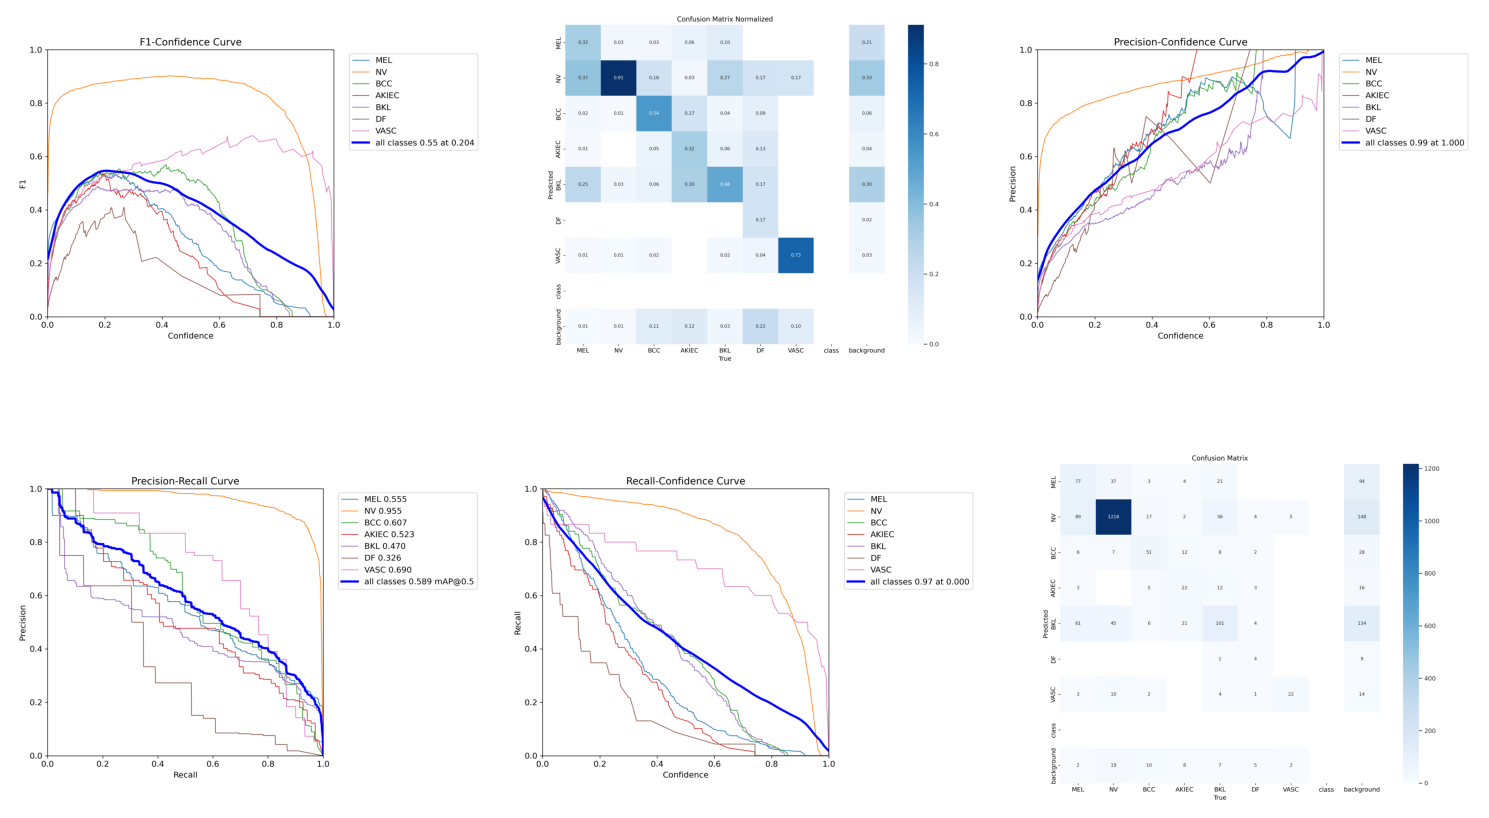

The various validation plots showcase that the model is, not unexpectedly, mediocre at this task. There are many off diagonal records in the confusion matrix and the precision-recall curve could be better. That could likely be fixed with more time for finetuning the model.


In [11]:
def benchmark(model: torch.nn.Module):
    result = model.val(data=output_directory / 'ham1000.yaml', imgsz=imgsz, half=False, device=device, verbose=True, batch=4, plots=True, split='test')
    return result

In [12]:
result = model.val(
    data=output_directory / 'ham1000.yaml', 
   imgsz=imgsz, 
   half=False, 
   device=device, 
   verbose=True, 
   batch=4, 
   plots=True, 
   split='test'
)

Ultralytics YOLOv8.2.9 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv9c summary (fused): 384 layers, 25325416 parameters, 18648 gradients, 102.4 GFLOPs


val: Scanning /kaggle/working/dataset/test... 2003 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2003/2003 [00:01<00:00, 1272.58it/s]


val: New cache created: /kaggle/working/dataset/test.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10, len(boxes) = 2003. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 501/501 [00:48<00:00, 10.36it/s]


                   all       2003       2003      0.492      0.644      0.589      0.456
                   MEL       2003        241      0.487      0.556      0.555      0.492
                    NV       2003       1336      0.812      0.959      0.955      0.865
                   BCC       2003         94      0.455      0.656      0.607      0.361
                 AKIEC       2003         69      0.449      0.493      0.523      0.342
                   BKL       2003        210      0.356      0.698       0.47       0.36
                    DF       2003         23      0.498      0.345      0.326      0.218
                  VASC       2003         30      0.384        0.8       0.69      0.555
Speed: 0.2ms preprocess, 19.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


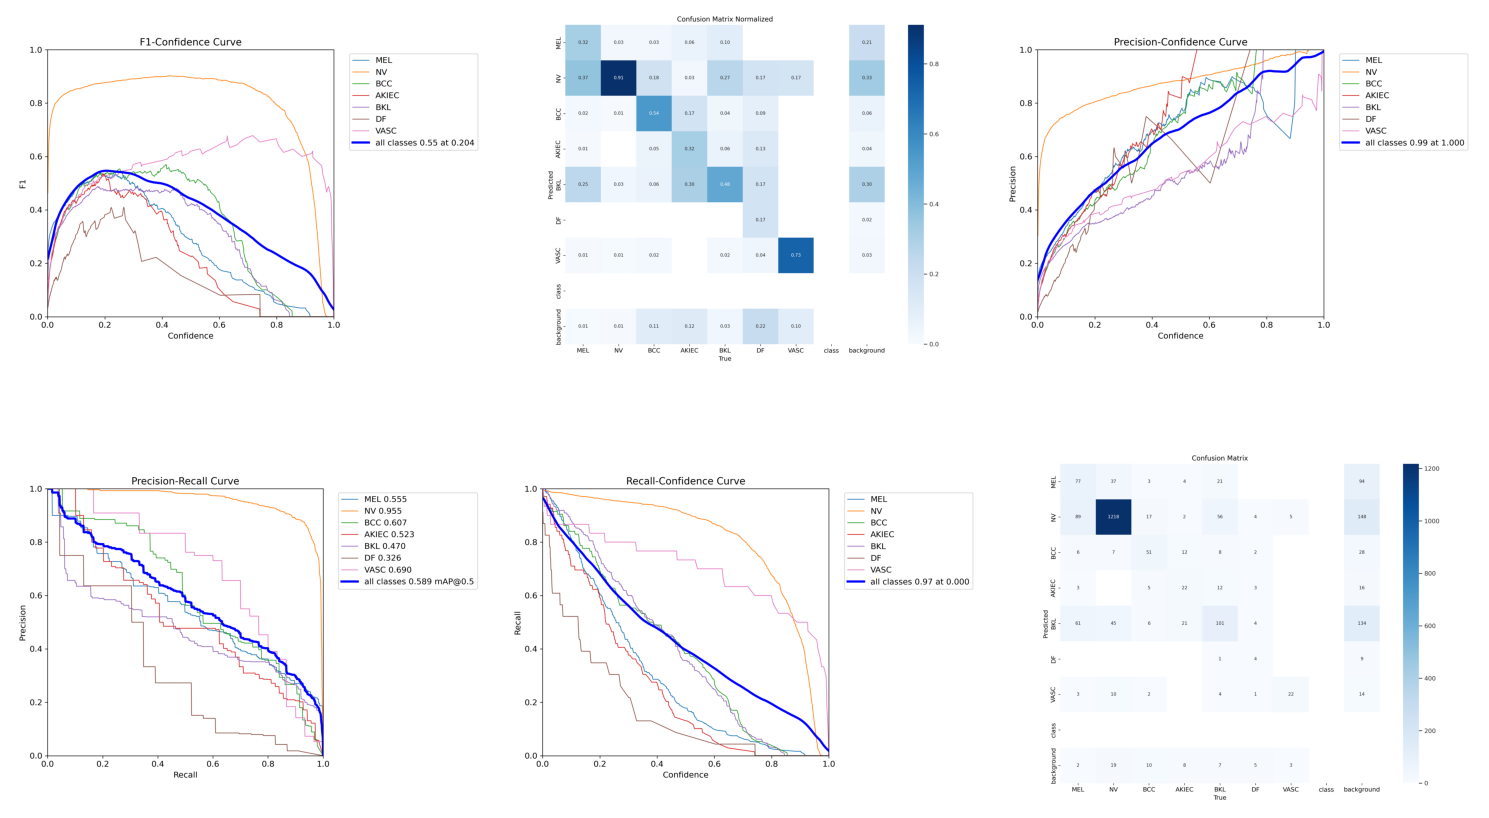

In [13]:
plots = glob('runs/detect/val/*.png')
plt.figure(figsize=(15, 10), layout='tight')
for i, file in enumerate(plots):
    plt.subplot(2, 3, i + 1)
    plot = skimage.io.imread(file)
    plt.imshow(plot)
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
plt.show()